## 3. Part 2 - House prices

In this second part, you will work on the house prices data set assembled and published by Dean De Cock. It's a set of 2,930 observations with 82 attributes each. The goal is to use the first 2,430 ones to fit and evaluate different models and use them to make predictions for the last 500 ones. Note that we don't provide the prices for those 500 houses, your task is to estimate them.

### Project files

Download the $house-prices.zip$ archive from the resource section. You should see the following files

* Detailed data description - documentation.txt
* The 2,430 data points with prices - house-prices.csv
* The remaining 500 without prices - house-prices-test.csv
* Example submission file - predictions-example.csv
* Data set source - source.txt

Create a $house-prices-solution.ipynb$ notebook to write your analysis. The notebook should also run with the $exts-ml$ environment.

### A quick look at the data

Here are the first five entries from $house-prices.csv$

https://d7whxh71cqykp.cloudfront.net/uploads/image/data/3784/houses-df.png

You can find a detailed description of each variable in the $documentation.txt$ file, but there are a few things to know.

* The $Order$ and PID variables are identifiers. They are not useful to predict house prices.
* The variables are not necessarily encoded consistently. For instance, MS SubClass (the type of dwelling) and MS Zoning (zoning classification) are both categorical variables, but one is encoded with numerical values and the other with short labels.
* The data isn't clean: there are incorrect and missing values, outliers and inconsistencies

You should address all these issues during the **data cleaning** stage.

### Data cleaning

Your analysis should include the necessary **data cleaning steps**. For instance

* Find and handle incorrect, missing values
* Correct inconsistencies in the variables
* Handle outliers

You are free to choose your preferred approach to handle each step. For instance, you might want to replace missing values with the average or the most frequent value or create an missing category. In any case, **justify your choices!**

### Feature encoding

Your analysis should include the necessary **feature encoding steps**. The $documentation.txt$ file labels each variable with its type. For categorical ones, it uses the ordinal, nominal and discrete classification.

* Ordinal variables - you can order the categories
* Nominal variables - no possible ordering
* Discrete variables - categories are integer values

The encoding depends on the type of variable and its meaning. For instance, the kitchen quality variable is on a scale from excellent to poor. Hence, it's an ordinal variable, and you can choose to apply one-hot encoding or define a numerical scale ex. excellent corresponds to 5 and poor to 1. In any case, **justify your choices**!

### Feature engineering

Your analysis should also include **feature engineering**. Here are a few ideas

* Create indicator variables ex. year of construction is older than some threshold
* Transformations ex. log-transforms, polynomials

Suggestion: write down your feature engineering ideas during the data exploration stage.

*Warning: Be careful when adding total counts (ex. the total number of rooms, living surface) and other linear combinations of the input features. Those variables don't add "modeling power" to the model if you keep the original features in the data and can lead to ill-conditioning and numerical issues. On the other hand, if you create such variables and remove the original features, it can be seen as a way to compress the information on fewer dimensions which can be useful for the simple and intermediate models where the number of variables is limited.*

### Model fitting

Your analysis should include an appropriate **baseline** and evaluate three different models ranging in complexity

* A **simple model** with two variables (three with the target variable)
* An **intermediate model** (between 10 and 20 variables)
* A **complex model** with all variables

The number of variables is only given as an indication, it's not a strict range. Also, it corresponds to the variables count before one-hot encoding. For the simple and intermediate models, you can choose the variables. You are free to choose your preferred approach for this variable selection step, but you should include a short comment to **explain your choice**.

*Example: I decide to choose variables v1, v2 and v3 for my simple model because I think that they provide a good overview of the house - or - I choose these variables because they are the most correlated with the target - or - I decide to test the SelectKBest object that I found in Scikit-learn to do automatic feature selection.*

### Regularization

Your analysis should include **regularization** for at least the complex model, tune its strength with **grid search** and plot the **validation curves.**

### Communicating the results

You are free to use any appropriate cost function to fit your models, with or without prices transformation ex. log-transformed. You can also choose the train/test split ratio ex. 50-50 split. However, **explain your choices** in the notebook.

You can also track different metrics to evaluate the performance of your models. However, make sure to print the **mean absolute error** (MAE) score **in dollars** for each one.

*Example: My simple model has an MAE of 25,123 thousand dollars - or - The mean MAE score of my model is .. ± .. dollars (std)*

Your analysis should also include a final visualization which summarizes the different models MAE scores. For instance, using a bar chart

https://d7whxh71cqykp.cloudfront.net/uploads/image/data/3785/bar-chart.svg

or even a box-plot if you decided to evaluate your models on several train/test splits

https://d7whxh71cqykp.cloudfront.net/uploads/image/data/3786/box-plot.svg

### Compute predictions

Make predictions for the 500 new houses from $house-prices-test.csv$ using each model and save them in a $.csv$ file.

* Predictions from your simple model - predictions-simple-model.csv
* Predictions from your intermediate model - predictions-intermediate-model.csv
* Predictions from your complex model - predictions-complex-model.csv

Your .csv files should contain two columns: the house PID and the predicted price. You can find a sample submission file in $predictions-example.csv$. 
<br>**Note**: The numbers in this example file are arbitrary and do not have any characteristics or relationships to the true values of the prediction set.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(r'house-price\house-prices.csv')
data_test = pd.read_csv(r'house-price\house-prices-test.csv')
print('Data shape:',data.shape)
print('Data test shape:',data_test.shape)

Data shape: (2430, 82)
Data test shape: (500, 81)


## (A) Data cleaning

In [3]:
data.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2430.000000,2.430000e+03,2430.000000,2010.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2410.000000,...,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000
mean,1469.478189,7.149375e+08,57.092593,69.201990,10243.557613,6.088889,5.569959,1971.167490,1984.238683,101.995436,...,93.917695,47.091770,22.294650,2.471605,16.529218,2.401235,56.179835,6.209465,2007.783539,180199.692593
std,843.236520,1.887339e+08,42.903254,23.486988,8353.925254,1.414621,1.116442,30.207931,20.751163,176.611699,...,128.106940,67.123846,62.386414,24.880245,56.822227,36.111988,616.661541,2.721942,1.311843,79607.467171
min,1.000000,5.263011e+08,20.000000,21.000000,1470.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,749.250000,5.284770e+08,20.000000,58.000000,7482.000000,5.000000,5.000000,1954.000000,1966.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129000.000000
50%,1470.500000,5.354541e+08,50.000000,68.000000,9500.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2193.500000,9.071352e+08,70.000000,80.000000,11604.500000,7.000000,6.000000,2000.000000,2003.000000,164.750000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213099.750000
max,2930.000000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [4]:
data.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

### MS SubClass (Nominal) - clean

In [5]:
# Don't seem to be any issue with this variable but will need to use one-hot encoding [Nominal]
data['MS SubClass'].unique()

array([ 60,  20, 160, 190,  50,  70, 120,  30,  90,  85,  45,  80, 180,
        75,  40, 150], dtype=int64)

In [6]:
data_test['MS SubClass'].unique()

array([ 50,  20,  60,  30,  80, 160,  90, 120,  70, 180, 190,  75,  45,
        85,  40], dtype=int64)

### MS Zoning (Nominal) - clean

In [7]:
# Don't seem to be any issue with this variable but will need to use one-hot-encoding [Nominal]
data['MS Zoning'].unique()

array(['RL', 'RM', 'FV', 'I (all)', 'C (all)', 'RH', 'A (agr)'],
      dtype=object)

In [8]:
data_test['MS Zoning'].unique()

array(['RL', 'C (all)', 'FV', 'RH', 'RM'], dtype=object)

### Lot Frontage (Continous) - fill na & handle outliers

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


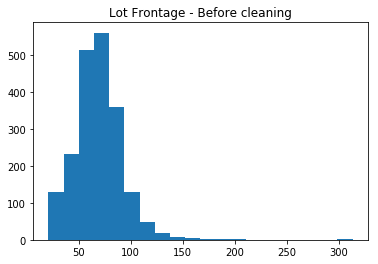

In [9]:
plt.hist(data['Lot Frontage'],bins=20)
#plt.scatter(data['Lot Frontage'], data['SalePrice'])
plt.title('Lot Frontage - Before cleaning')
plt.show()

In [10]:
# Decision to handle outliers before handling NA. This would avoid impacting mean and std
# In fact above comment wouldn't impact as I decided to consier outliers above 250 $ instead of using z-score which would have been impacted but lower boundary at 0

#data[(np.abs((data['Lot Frontage']- data['Lot Frontage'].mean()) / data['Lot Frontage'].std()) > 5)]['Lot Frontage']
#(np.abs((data['Lot Frontage']- data['Lot Frontage'].mean()) / data['Lot Frontage'].std()) > 2).sum()

outlier = data['Lot Frontage'] > 250
outlier.sum()

2

In [11]:
print('Count NA values:',data['Lot Frontage'].isnull().sum())
print('Mean value {:.0f}'.format(data['Lot Frontage'].mean()))

Count NA values: 420
Mean value 69


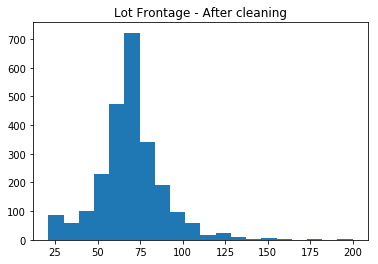

In [12]:
# replace NA values with mean
data['Lot Frontage'].fillna(value=data['Lot Frontage'].mean(),inplace=True)
plt.hist(data[~outlier]['Lot Frontage'],bins=20)
plt.title('Lot Frontage - After cleaning')
plt.show()

In [13]:
# handle test data
print(data_test['Lot Frontage'].isnull().sum())
data_test['Lot Frontage'].fillna(value=data['Lot Frontage'].mean(),inplace=True)

70


### Lot Area (Continuous) - handle outliers

In [14]:
# No NA values
data['Lot Area'].isnull().sum()

0

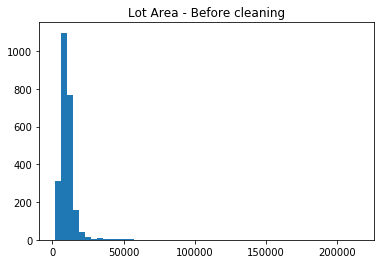

In [15]:
plt.hist(data['Lot Area'], bins=50)
plt.title('Lot Area - Before cleaning')
plt.show()

In [16]:
data[(np.abs((data['Lot Area']- data['Lot Area'].mean()) / data['Lot Area'].std()) > 2)]['Lot Area']

34       56600
71       39290
101      32668
113      57200
267     164660
279      31220
341      33120
441      53107
466      39384
537      29959
685      70761
842      50271
979      43500
1064     33983
1235     45600
1304     27650
1464     51974
1500     63887
1513    159000
1612     39104
1752     36500
1799     53227
1802     35133
1815     41600
1886     27697
1898     28698
1970     31770
2056     47007
2061     46589
2183     34650
2228     32463
2257    215245
2316    115149
2396     31250
2409     50102
Name: Lot Area, dtype: int64

In [17]:
# Decided to remove outliers with z-score higher than 2. Looking at data it seems reasonable to consider tham as outliers and only removes 35 data points
# Interesting to note that the total number of rows considered outliers is stay which means both values considered as Lot Forntage outliers are also Lot Area outliers
outlier = (np.abs((data['Lot Area']- data['Lot Area'].mean()) / data['Lot Area'].std()) > 2) | outlier
outlier.sum()

35

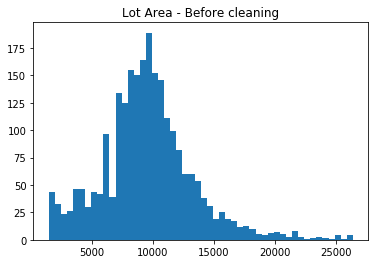

In [18]:
plt.hist(data[~outlier]['Lot Area'], bins=50)
plt.title('Lot Area - Before cleaning')
plt.show()

In [19]:
# handle test data
data_test['Lot Area'].isnull().sum()

0

### Street (Nominal) - clean

In [20]:
data['Street'].unique()

array(['Pave', 'Grvl'], dtype=object)

In [21]:
# handle test data
data_test['Street'].unique()

array(['Pave', 'Grvl'], dtype=object)

### Alley (Nominal) - fill na

In [22]:
data['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [23]:
# large number of 'No access'
data['Alley'].fillna(value='No access',inplace=True)
data[['Alley','Order']].groupby('Alley').count()

,Order
Alley,
Grvl,104
No access,2267
Pave,59


In [24]:
# handle test data
data_test['Alley'].unique()

array([nan, 'Pave', 'Grvl'], dtype=object)

In [25]:
# large number of 'No access'
data_test['Alley'].fillna(value='No access',inplace=True)
data_test[['Alley','Order']].groupby('Alley').count()

,Order
Alley,
Grvl,16
No access,465
Pave,19


### Lot Shape (Ordinal) - Regroup categories

In [26]:
data['Lot Shape'].unique()

array(['IR1', 'Reg', 'IR2', 'IR3'], dtype=object)

In [27]:
# SalePrice difference seems to be mostly between Regular vs Irregular (no matter which category). Therefore decide to regrou pirregulars together
data[['Lot Shape','SalePrice']].groupby('Lot Shape').mean()

,SalePrice
Lot Shape,
IR1,210918.299043
IR2,227798.257576
IR3,211418.928571
Reg,160873.847424


In [28]:
# Update for both train and test set
data['Lot Shape'].replace({'IR1': 'IR','IR2': 'IR','IR3': 'IR'},inplace=True)
data_test['Lot Shape'].replace({'IR1': 'IR','IR2': 'IR','IR3': 'IR'},inplace=True)

### Land Contour (Nominal) - clean

In [29]:
data['Land Contour'].unique()

array(['Lvl', 'Bnk', 'HLS', 'Low'], dtype=object)

In [30]:
# handle test data
data_test['Land Contour'].unique()

array(['HLS', 'Low', 'Lvl', 'Bnk'], dtype=object)

### Utilities (Ordinal) - convert to numerical scale

In [31]:
# No ELO values
data['Utilities'].unique()

array(['AllPub', 'NoSewr', 'NoSeWa'], dtype=object)

In [32]:
# Decide to convert to numerical based on number of utility type available
# Update for both train and test set
data['Utilities'].replace({'AllPub': 5,'NoSewr': 3,'NoSeWa': 2,'ELO':1},inplace=True)
data_test['Utilities'].replace({'AllPub': 5,'NoSewr': 3,'NoSeWa': 2,'ELO':1},inplace=True)

### Lot Config (Nominal) - clean

In [33]:
data['Lot Config'].unique()

array(['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'], dtype=object)

In [34]:
# handle test data
data_test['Lot Config'].unique()

array(['Corner', 'Inside', 'CulDSac', 'FR2', 'FR3'], dtype=object)

### Land Slope (Ordinal) - clean

In [35]:
data['Land Slope'].unique()

array(['Gtl', 'Mod', 'Sev'], dtype=object)

In [36]:
# Very low number of Mod and Sev. Decide to keep as it is
data[['Land Slope','Order']].groupby('Land Slope').agg({'Order':{'Count':'count','Mean':'mean'}})

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Order             
           Count         Mean
Land Slope                   
Gtl         2312  1465.721021
Mod          102  1549.401961
Sev           16  1502.875000

In [37]:
# handle test data
data_test['Land Slope'].unique()

array(['Mod', 'Gtl'], dtype=object)

### Neighbordhood (Nominal) - clean

In [38]:
data['Neighborhood'].unique()

array(['Gilbert', 'NAmes', 'MeadowV', 'OldTown', 'SawyerW', 'Somerst',
       'Timber', 'Edwards', 'NWAmes', 'Mitchel', 'CollgCr', 'NridgHt',
       'IDOTRR', 'NoRidge', 'GrnHill', 'Crawfor', 'StoneBr', 'BrDale',
       'BrkSide', 'Landmrk', 'SWISU', 'Sawyer', 'ClearCr', 'Greens',
       'Veenker', 'Blueste', 'NPkVill', 'Blmngtn'], dtype=object)

In [39]:
# handle test data
data_test['Neighborhood'].unique()

array(['Crawfor', 'CollgCr', 'NridgHt', 'NAmes', 'IDOTRR', 'SawyerW',
       'Edwards', 'Timber', 'SWISU', 'Somerst', 'Gilbert', 'NoRidge',
       'NWAmes', 'Sawyer', 'Blmngtn', 'OldTown', 'Mitchel', 'BrkSide',
       'ClearCr', 'MeadowV', 'Blueste', 'NPkVill', 'BrDale', 'StoneBr',
       'Veenker'], dtype=object)

### Condition 1 & 2 (Nominal) - Clean

In [40]:
data['Condition 1'].unique()

array(['Norm', 'Feedr', 'PosN', 'RRAe', 'Artery', 'PosA', 'RRAn', 'RRNn',
       'RRNe'], dtype=object)

In [41]:
data['Condition 2'].unique()

array(['Norm', 'PosA', 'Feedr', 'Artery', 'RRNn', 'PosN', 'RRAe', 'RRAn'],
      dtype=object)

In [42]:
# handle test data
data_test['Condition 1'].unique()

array(['Norm', 'Feedr', 'Artery', 'RRAn', 'RRNe', 'PosN', 'RRNn', 'RRAe',
       'PosA'], dtype=object)

In [43]:
# handle test data
data_test['Condition 2'].unique()

array(['Norm', 'PosN', 'Feedr'], dtype=object)

### Bldg Type (Nominal) - clean

In [44]:
data['Bldg Type'].unique()

array(['1Fam', 'Twnhs', '2fmCon', 'TwnhsE', 'Duplex'], dtype=object)

### House Style (Nominal) - clean

In [45]:
data['House Style'].unique()

array(['2Story', '1Story', '2.5Unf', '1.5Fin', 'SFoyer', '1.5Unf', 'SLvl',
       '2.5Fin'], dtype=object)

### Overall Qual & Overall Cond (Ordinal) - clean

In [46]:
data['Overall Qual'].unique()

array([ 7,  6,  4,  5,  8,  9, 10,  3,  1,  2], dtype=int64)

In [47]:
data['Overall Cond'].unique()

array([5, 6, 4, 8, 7, 1, 9, 3, 2], dtype=int64)

In [48]:
data['Overall Qual'].isnull().sum()

0

In [49]:
data['Overall Cond'].isnull().sum()

0

In [50]:
# handle test data
print(data_test['Overall Qual'].isnull().sum())
print(data_test['Overall Cond'].isnull().sum())

0
0


### Year Built (Discrete) - clean (potential of bucketing)

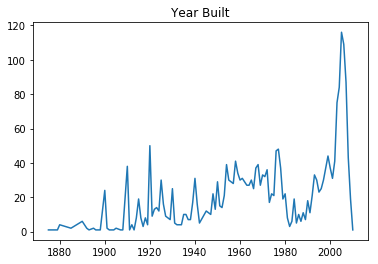

In [51]:
plt.plot(data[['Year Built','Order']].groupby('Year Built').count())
plt.title('Year Built')
plt.show()

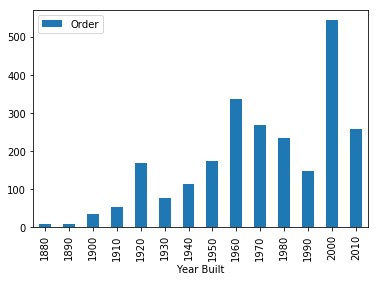

In [52]:
data['Year Built'] = round(data['Year Built'],-1)
data[['Year Built','Order']].groupby('Year Built').count().plot(kind='bar')
plt.show()

In [53]:
# handle test data
data_test['Year Built'] = round(data_test['Year Built'],-1)

### Year Remod/Add (Discrete) - handle value stuck on 1950

Count Nan: 0


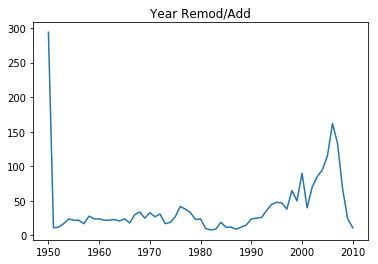

In [54]:
# seems strange that we have that many data around 1950 ond not data before
# Suggest to make some adjustements where 'Year Built' is 
print('Count Nan:',data['Year Remod/Add'].isnull().sum())
plt.plot(data[['Year Remod/Add','Order']].groupby('Year Remod/Add').count())
plt.title('Year Remod/Add')
plt.show()

Count values on 1950: 294


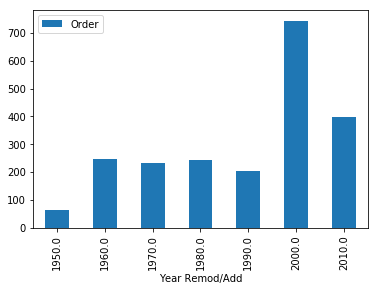

In [55]:
print('Count values on 1950:',data['Year Remod/Add'].apply(lambda x: np.where(x == 1950, np.nan,x)).isnull().sum())
# updating those values with Nan as data are probably incorrect
data['Year Remod/Add'] = data['Year Remod/Add'].apply(lambda x: np.where(x == 1950, np.nan,x))
# Also rounding results to 10
data['Year Remod/Add'] = round(data['Year Remod/Add'],-1)
data[['Year Remod/Add','Order']].groupby('Year Remod/Add').count().plot(kind='bar')
plt.show()

In [56]:
# handle test data
# updating those values with Nan as data are probably incorrect
data_test['Year Remod/Add'] = data_test['Year Remod/Add'].apply(lambda x: np.where(x == 1950, np.nan,x))
# Also rounding results to 10
data_test['Year Remod/Add'] = round(data_test['Year Remod/Add'],-1)

### Roof Style & Roof Matl (Nominal) - clean

In [57]:
data['Roof Style'].unique()

array(['Gable', 'Hip', 'Flat', 'Gambrel', 'Mansard', 'Shed'], dtype=object)

In [58]:
data['Roof Matl'].unique()

array(['CompShg', 'Tar&Grv', 'WdShake', 'WdShngl', 'Metal', 'ClyTile',
       'Membran'], dtype=object)

In [59]:
# handle test data
data_test['Roof Style'].unique()

array(['Gable', 'Mansard', 'Hip', 'Gambrel', 'Flat'], dtype=object)

In [60]:
data['Roof Matl'].unique()

array(['CompShg', 'Tar&Grv', 'WdShake', 'WdShngl', 'Metal', 'ClyTile',
       'Membran'], dtype=object)

### Exterior 1st & 2nd (Nominal) - clean

In [61]:
data['Exterior 1st'].unique()

array(['VinylSd', 'Wd Sdng', 'CemntBd', 'BrkFace', 'MetalSd', 'Plywood',
       'HdBoard', 'Stucco', 'Stone', 'CBlock', 'AsbShng', 'WdShing',
       'BrkComm', 'PreCast', 'AsphShn', 'ImStucc'], dtype=object)

In [62]:
data['Exterior 2nd'].unique()

array(['VinylSd', 'Wd Sdng', 'CmentBd', 'BrkFace', 'MetalSd', 'Plywood',
       'HdBoard', 'Stucco', 'Wd Shng', 'CBlock', 'Stone', 'ImStucc',
       'AsbShng', 'Brk Cmn', 'AsphShn', 'PreCast'], dtype=object)

In [63]:
# handle test data
data_test['Exterior 1st'].unique()

array(['MetalSd', 'VinylSd', 'Wd Sdng', 'AsbShng', 'Plywood', 'HdBoard',
       'CemntBd', 'WdShing', 'BrkFace', 'Stucco'], dtype=object)

In [64]:
data_test['Exterior 2nd'].unique()

array(['MetalSd', 'VinylSd', 'Wd Sdng', 'AsbShng', 'Plywood', 'CmentBd',
       'Wd Shng', 'HdBoard', 'Stucco', 'BrkFace', 'Brk Cmn', 'Stone',
       'ImStucc', 'Other', 'CBlock'], dtype=object)

### Mas Vnr Type (Nominal) - handle NAs

In [65]:
data['Mas Vnr Type'].unique()

array(['None', 'BrkFace', 'Stone', nan, 'BrkCmn', 'CBlock'], dtype=object)

In [66]:
data[['Mas Vnr Type','Order']].groupby('Mas Vnr Type').count()

,Order
Mas Vnr Type,
BrkCmn,21
BrkFace,736
CBlock,1
None,1442
Stone,210


In [67]:
# I decided to replace NAs with None as it is the higher number of value and assume best representation as well
print('Count NA:',data['Mas Vnr Type'].isnull().sum())
data['Mas Vnr Type'].fillna(value='None',inplace=True)

Count NA: 20


In [68]:
# handle test data
data_test['Mas Vnr Type'].fillna(value='None',inplace=True)

### Mas Vnr Area (Continous) - handle outlier (1x)

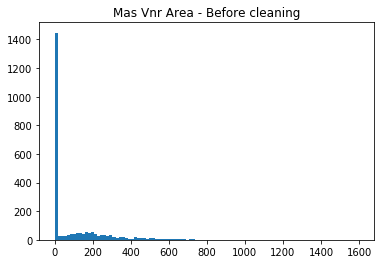

In [69]:
# This is a large number of properties with Mas Vnr Area = 0 but seems aligned with Mas Vnr Type = None numbers.
plt.hist(data['Mas Vnr Area'], bins=100)
plt.title('Mas Vnr Area - Before cleaning')
plt.show()

In [70]:
# This is a large number of properties with Mas Vnr Area = 0 but seems aligned with Mas Vnr Type = None numbers.
print('Count NA:',data['Mas Vnr Area'].isnull().sum())
data['Mas Vnr Area'].fillna(value=0,inplace=True)

Count NA: 20


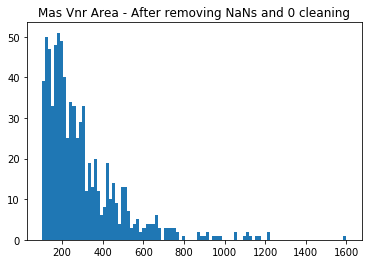

In [71]:
plt.hist(data[data['Mas Vnr Area'] > 100]['Mas Vnr Area'], bins=100)
plt.title('Mas Vnr Area - After removing NaNs and 0 cleaning')
plt.show()

In [72]:
# Decided to tag as outlier the one value above 1500
outlier = (data['Mas Vnr Area']  > 1500) | outlier
outlier.sum()

36

In [73]:
# handle test data
data_test['Mas Vnr Area'].fillna(value=0,inplace=True)

### Exter Qual & Exter Cond (Ordinal) - convert to numerical scale

In [74]:
data['Exter Qual'].unique()

array(['Gd', 'TA', 'Fa', 'Ex'], dtype=object)

In [75]:
data['Exter Cond'].unique()

array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [76]:
# Decide to convert to numerical based
# Update for both train and test set
data['Exter Qual'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data_test['Exter Qual'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)

In [77]:
# Decide to convert to numerical based
# Update for both train and test set
data['Exter Cond'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data_test['Exter Cond'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)

### Foundation (Nominal) - clean

In [78]:
data['Foundation'].unique()

array(['PConc', 'CBlock', 'BrkTil', 'Slab', 'Stone', 'Wood'], dtype=object)

In [79]:
# handle test data
data_test['Foundation'].unique()

array(['CBlock', 'PConc', 'Stone', 'Slab', 'BrkTil'], dtype=object)

### Bsmt Qual & Bsmt Cond & Bsmt Exposure (Ordinal) - convert to numerical scale

In [80]:
data['Bsmt Qual'].unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa', 'Po'], dtype=object)

In [81]:
data['Bsmt Cond'].unique()

array(['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'], dtype=object)

In [82]:
data['Bsmt Exposure'].unique()

array(['No', 'Av', 'Mn', 'Gd', nan], dtype=object)

In [83]:
data['Bsmt Qual'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data_test['Bsmt Qual'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data['Bsmt Qual'].fillna(value=0,inplace=True)
data_test['Bsmt Qual'].fillna(value=0,inplace=True)

In [84]:
data['Bsmt Cond'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data_test['Bsmt Cond'].replace({'Ex': 5,'Gd': 4,'TA': 3,'Fa':2,'Po':1},inplace=True)
data['Bsmt Cond'].fillna(value=0,inplace=True)
data_test['Bsmt Cond'].fillna(value=0,inplace=True)

In [85]:
data['Bsmt Exposure'].replace({'Gd': 4,'Av': 3,'Mn': 2,'No':1},inplace=True)
data_test['Bsmt Exposure'].replace({'Gd': 4,'Av': 3,'Mn': 2,'No':1},inplace=True)
data['Bsmt Exposure'].fillna(value=0,inplace=True)
data_test['Bsmt Exposure'].fillna(value=0,inplace=True)

### BsmtFin Type 1 & BsmtFin Type 2 (Ordinal) - convert to numerical scale

In [86]:
data['BsmtFin Type 1'].unique()

array(['GLQ', 'Unf', 'Rec', 'LwQ', 'BLQ', 'ALQ', nan], dtype=object)

In [87]:
data['BsmtFin Type 2'].unique()

array(['Unf', 'LwQ', 'BLQ', nan, 'Rec', 'ALQ', 'GLQ'], dtype=object)

In [88]:
data['BsmtFin Type 1'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1},inplace=True)
data_test['BsmtFin Type 1'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1},inplace=True)
data['BsmtFin Type 1'].fillna(value=0,inplace=True)
data_test['BsmtFin Type 1'].fillna(value=0,inplace=True)

In [89]:
data['BsmtFin Type 2'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1},inplace=True)
data_test['BsmtFin Type 2'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1},inplace=True)
data['BsmtFin Type 2'].fillna(value=0,inplace=True)
data_test['BsmtFin Type 2'].fillna(value=0,inplace=True)

### BsmtFin SF 1 + 2 & Bsmt UNF SF & Total Bsmt SF (Continuous) - handle outliers

Count NaN SF 1: 1
Count >0 SF 1: 1656


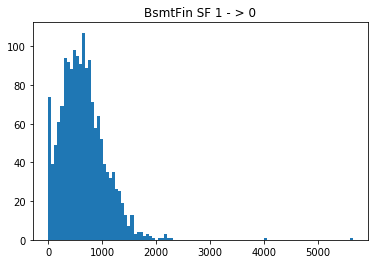

In [90]:
print('Count NaN SF 1:',data['BsmtFin SF 1'].isnull().sum())
print('Count >0 SF 1:',data[data['BsmtFin SF 1']>0]['BsmtFin SF 1'].count())
data['BsmtFin SF 1'].fillna(value=0,inplace=True)
data_test['BsmtFin SF 1'].fillna(value=0,inplace=True) # handle test data
plt.hist(data[data['BsmtFin SF 1'] > 0]['BsmtFin SF 1'], bins=100)
plt.title('BsmtFin SF 1 - > 0')
plt.show()

In [91]:
# Decide to tag as outlier values above 3000
outlier = (data['BsmtFin SF 1']  > 3000) | outlier
outlier.sum()
# We stay at 36 it means value which were outliers for this variable where also outliers in other variables

36

Count NaN SF 2: 1
Count >0 SF 2: 294


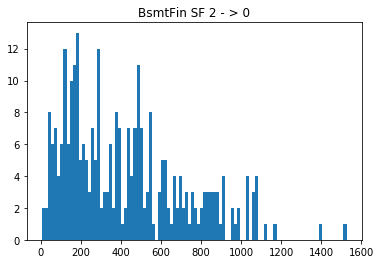

In [92]:
print('Count NaN SF 2:',data['BsmtFin SF 2'].isnull().sum())
print('Count >0 SF 2:',data[data['BsmtFin SF 2']>0]['BsmtFin SF 2'].count())
data['BsmtFin SF 2'].fillna(value=0,inplace=True)
data_test['BsmtFin SF 2'].fillna(value=0,inplace=True) # handle test data
plt.hist(data[data['BsmtFin SF 2'] > 0]['BsmtFin SF 2'], bins=100)
plt.title('BsmtFin SF 2 - > 0')
plt.show()
# Overall less than 300 values above 0. Decide not to remove any values as outliers here

Count NaN Unf: 1
Count >0 Unf: 2219


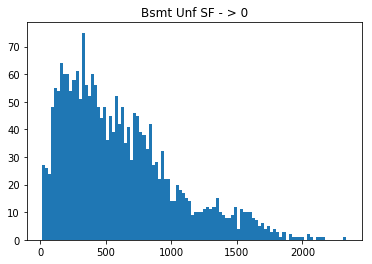

In [93]:
print('Count NaN Unf:',data['Bsmt Unf SF'].isnull().sum())
print('Count >0 Unf:',data[data['Bsmt Unf SF']>0]['Bsmt Unf SF'].count())
data['Bsmt Unf SF'].fillna(value=0,inplace=True)
data_test['Bsmt Unf SF'].fillna(value=0,inplace=True) # handle test data
plt.hist(data[data['Bsmt Unf SF'] > 0]['Bsmt Unf SF'], bins=100)
plt.title('Bsmt Unf SF - > 0')
plt.show()
# Decide to not consider as values as outliers

Count NaN Total Bsmt: 1
Count >0 Total Bsmt: 2359


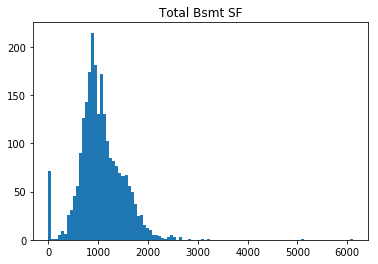

In [94]:
print('Count NaN Total Bsmt:',data['Total Bsmt SF'].isnull().sum())
print('Count >0 Total Bsmt:',data[data['Total Bsmt SF']>0]['Total Bsmt SF'].count())
data['Total Bsmt SF'].fillna(value=0,inplace=True)
data_test['Total Bsmt SF'].fillna(value=0,inplace=True) # handle test data
plt.hist(data[data['Total Bsmt SF'] > -1]['Total Bsmt SF'], bins=100)
plt.title('Total Bsmt SF')
plt.show()

In [95]:
(np.abs((data[data['Total Bsmt SF']>0]['Total Bsmt SF'] - data[data['Total Bsmt SF']>0]['Total Bsmt SF'].mean()) / data[data['Total Bsmt SF']>0]['Total Bsmt SF'].std()) > 3).sum()
# Considering only values above 0 to identify outliers
# 21 z-score values above abs(3) - choose 3 std as 2 seems too restrictive

21

In [96]:
mean_total_sf = data[data['Total Bsmt SF']>0]['Total Bsmt SF'].mean()
std_total_sf = data[data['Total Bsmt SF']>0]['Total Bsmt SF'].std()
data[((data['Total Bsmt SF'] != 0) & ((np.abs(data['Total Bsmt SF']-mean_total_sf) / std_total_sf) > 3))]['Total Bsmt SF']

71      5095.0
102     2396.0
237     2444.0
309     2524.0
321     2535.0
503     2552.0
534     2418.0
602     3206.0
1102    2633.0
1191    2458.0
1201    2492.0
1213    2630.0
1464    2660.0
1500    6110.0
1519    2330.0
1588    2452.0
1602    2461.0
1843    2846.0
1856    2392.0
2393    3094.0
2411    2320.0
Name: Total Bsmt SF, dtype: float64

In [97]:
#((data['Total Bsmt SF'] != 0) & ((np.abs(data['Total Bsmt SF']-mean_total_sf) / std_total_sf) > 3))
outlier = ((data['Total Bsmt SF'] != 0) & ((np.abs(data['Total Bsmt SF']-mean_total_sf) / std_total_sf) > 3)) | outlier
outlier.sum()
# We now have 18 more outliers (54 - 36). Means there was some minor overlap (3 entries)

54

### Heating (Nominal) - clean

In [98]:
data['Heating'].unique()

array(['GasA', 'GasW', 'Wall', 'Grav', 'OthW', 'Floor'], dtype=object)

In [99]:
# handle test data
data_test['Heating'].unique()

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW'], dtype=object)

### HeatingQC (Ordinal) - convert to numerical scale

In [100]:
# Decide to create scale starting at 1 as 0 would have means inexistant
data['Heating QC'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
data_test['Heating QC'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)

### Central Air (Nominal) - clean

In [101]:
data['Central Air'].unique()

array(['Y', 'N'], dtype=object)

In [102]:
# handle test data
data_test['Central Air'].unique()

array(['Y', 'N'], dtype=object)

### Electrical (Ordinal) - handle Nan

In [103]:
print('Count NaN:',data['Electrical'].isnull().sum())
data['Electrical'].unique()
# I don't know the scale of quality between each types and therefore deciding to keep as Nominal

Count NaN: 1


array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', nan, 'Mix'], dtype=object)

In [104]:
# check what is the most common type to assign the only Nan to this type
data[['Electrical','Order']].groupby('Electrical').count().sort_values(by='Order',ascending=False)

,Order
Electrical,
SBrkr,2223
FuseA,160
FuseF,38
FuseP,7
Mix,1


In [105]:
data['Electrical'].fillna(value='SBrkr',inplace=True)

In [106]:
# handle test data
data_test['Electrical'].fillna(value='SBrkr',inplace=True)

### 1st & 2nd Flr SF (Continuous) - handle outliers 1st Floor

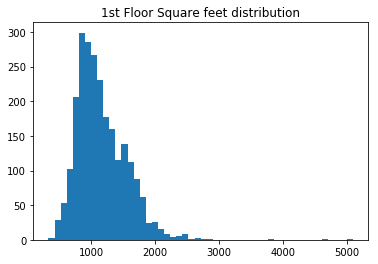

In [107]:
plt.hist(data['1st Flr SF'],bins=50)
plt.title('1st Floor Square feet distribution')
plt.show()

In [108]:
# creating function for z-score as I realize I am re-writting this part of the code several times
def z_score(x):
    return np.abs((x - x.mean()) / x.std())

In [109]:
(z_score(data['1st Flr SF']) > 3).sum()
# considering 3 std for outliers we can identify 23 of them. Let's have a look at them

23

In [110]:
data[z_score(data['1st Flr SF']) > 3]['1st Flr SF']
# All of them are large surface

71      5095
89      2898
101     2515
102     2411
237     2444
272     2726
309     2524
321     2470
503     2552
534     2464
834     2422
1102    2633
1191    2490
1201    2492
1213    2674
1500    4692
1519    2364
1588    2452
1602    2497
1843    2696
1856    2392
2056    3820
2393    2402
Name: 1st Flr SF, dtype: int64

In [111]:
outlier = (z_score(data['1st Flr SF']) > 3) | outlier
outlier.sum()
# We now have 3 more outliers (57 - 54). Means there was major overlap (3 entries)

57

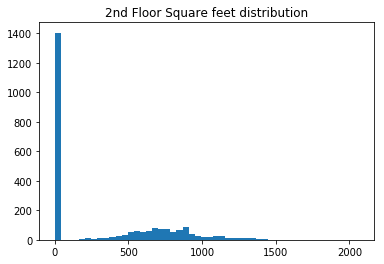

In [112]:
plt.hist(data['2nd Flr SF'],bins=50)
plt.title('2nd Floor Square feet distribution')
plt.show()

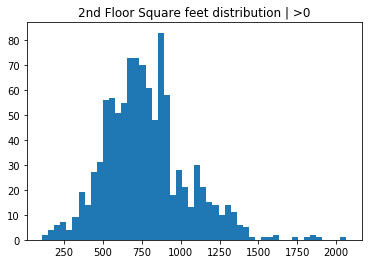

In [113]:
plt.hist(data[data['2nd Flr SF'] > 0]['2nd Flr SF'],bins=50)
plt.title('2nd Floor Square feet distribution | >0')
plt.show()
# Decided to not remove any outliers

### Low Qual Fin SF (Continous) - clean

Count Low Qual = 0: 2400


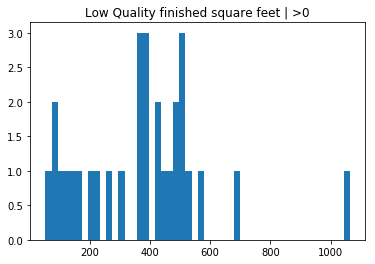

In [114]:
print('Count Low Qual = 0:',(data['Low Qual Fin SF'] == 0).sum())
plt.hist(data[data['Low Qual Fin SF'] != 0]['Low Qual Fin SF'], bins=50)
plt.title('Low Quality finished square feet | >0')
plt.show()

### Gr Liv Area (Continous)

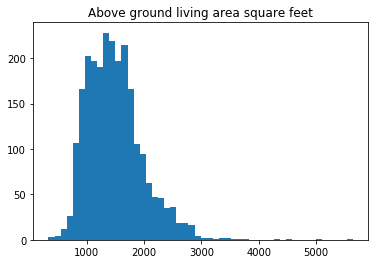

In [115]:
plt.hist(data['Gr Liv Area'], bins=50)
plt.title('Above ground living area square feet')
plt.show()

In [116]:
print('Count data points above 3 std:',(z_score(data['Gr Liv Area']) > 3).sum())
data[(z_score(data['Gr Liv Area']) > 3)]['Gr Liv Area']
# below list of entries to be tagged as outliers

Count data points above 3 std: 16


71      5095
102     4476
237     4316
306     3672
635     3086
647     3608
838     3500
895     3078
1072    3395
1152    3238
1500    5642
1582    3112
1724    3390
1927    3194
2056    3820
2092    3493
Name: Gr Liv Area, dtype: int64

In [117]:
outlier = (z_score(data['Gr Liv Area']) > 3) | outlier
outlier.sum()
# We now have 11 more outliers (68 - 57). Means there was some overlap (5 entries)

68

### Bsmt Full Bath & Bsmt Half Bath & Full Bath & Half Bath (Discrete) - handle NaNs

In [118]:
print('Count NaNs:',data['Bsmt Full Bath'].isnull().sum())
data['Bsmt Full Bath'].unique()

Count NaNs: 2


array([ 0.,  1., nan,  3.,  2.])

In [119]:
# fill NaNs with 0 as no data probably means 0
data['Bsmt Full Bath'].fillna(value=0, inplace=True)
data_test['Bsmt Full Bath'].fillna(value=0, inplace=True) # handle test data

In [120]:
print('Count NaNs:',data['Bsmt Half Bath'].isnull().sum())
data['Bsmt Half Bath'].unique()

Count NaNs: 2


array([ 0.,  1., nan,  2.])

In [121]:
# fill NaNs with 0 as no data probably means 0
data['Bsmt Half Bath'].fillna(value=0, inplace=True)
data_test['Bsmt Half Bath'].fillna(value=0, inplace=True) # handle test data

In [122]:
print('Count NaNs:',data['Full Bath'].isnull().sum())
data['Full Bath'].unique()

Count NaNs: 0


array([2, 1, 3, 0, 4], dtype=int64)

In [123]:
print('Count NaNs:',data['Full Bath'].isnull().sum())
data['Half Bath'].unique()

Count NaNs: 0


array([1, 0, 2], dtype=int64)

In [124]:
# handle test data
data_test['Full Bath'].unique()

array([1, 2, 0, 3, 4], dtype=int64)

In [125]:
data_test['Half Bath'].unique()

array([1, 0, 2], dtype=int64)

### Bedroom & Kitchen (Discrete) - clean but watch column name

In [126]:
print('Count NaNs:',data['Bedroom AbvGr'].isnull().sum())
data['Bedroom AbvGr'].unique()

Count NaNs: 0


array([4, 2, 3, 1, 5, 0, 6, 8], dtype=int64)

In [127]:
print('Count NaNs:',data['Kitchen AbvGr'].isnull().sum())
data['Kitchen AbvGr'].unique()

Count NaNs: 0


array([1, 2, 3, 0], dtype=int64)

### Kitchen Qual (Ordinal) - convert to numerical scale

In [128]:
print('Count NaNs:',data['Kitchen Qual'].isnull().sum())
data['Kitchen Qual'].unique()

Count NaNs: 0


array(['Gd', 'TA', 'Ex', 'Fa', 'Po'], dtype=object)

In [129]:
data['Kitchen Qual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
data_test['Kitchen Qual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)

### TotRmsAbvGrd (Discrete) - clean

In [130]:
print('Count NaNs:',data['TotRms AbvGrd'].isnull().sum())
data['TotRms AbvGrd'].unique()

Count NaNs: 0


array([ 8,  5,  6,  9,  7,  4, 10, 12, 11, 15,  3,  2, 14, 13],
      dtype=int64)

### Functional (Ordinal) - convert to numerical scale

In [131]:
print('Count NaNs:',data['Functional'].isnull().sum())
data['Functional'].unique()

Count NaNs: 0


array(['Typ', 'Mod', 'Maj1', 'Min2', 'Min1', 'Maj2', 'Sal', 'Sev'],
      dtype=object)

In [132]:
data['Functional'].replace({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1},inplace=True)
data_test['Functional'].replace({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1},inplace=True)

### Fireplaces (Discrete) - clean

In [133]:
print('Count NaNs:',data['Fireplaces'].isnull().sum())
data['Fireplaces'].unique()

Count NaNs: 0


array([1, 0, 2, 3, 4], dtype=int64)

In [134]:
# handle test data
data_test['Fireplaces'].unique()

array([1, 0, 2, 3], dtype=int64)

### FireplacesQu (Ordinal) - convert to numerical scale

In [135]:
print('Count NaNs:',data['Fireplace Qu'].isnull().sum())
data['Fireplace Qu'].unique()

Count NaNs: 1186


array(['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'], dtype=object)

In [136]:
data['Fireplace Qu'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
data['Fireplace Qu'].fillna(value=0,inplace=True)
data_test['Fireplace Qu'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
data_test['Fireplace Qu'].fillna(value=0,inplace=True)

### Garage Type (Nominal) - handle NaNs

In [137]:
print('Count NaNs:',data['Garage Type'].isnull().sum())
data['Garage Type'].unique()

Count NaNs: 136


array(['BuiltIn', 'Attchd', 'Detchd', nan, '2Types', 'Basment', 'CarPort'],
      dtype=object)

In [138]:
# NaN mean 'No Garage'
data['Garage Type'].fillna(value='No Garage',inplace=True)
data_test['Garage Type'].fillna(value='No Garage',inplace=True) # handle test data

### Garage Yr Blt (Discrete) - handle NaNs

Count NaNs: 138


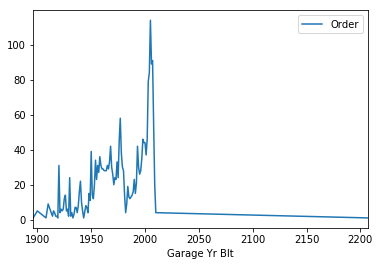

In [139]:
print('Count NaNs:',data['Garage Yr Blt'].isnull().sum())
data[['Garage Yr Blt','Order']].groupby('Garage Yr Blt').count().plot()
plt.show()

In [140]:
x = data[data['Garage Yr Blt'] > 2010]['Garage Yr Blt']
data['Garage Yr Blt'].replace(x,np.nan,inplace=True)
data['Garage Yr Blt'] = round(data['Garage Yr Blt'],-1)

# handle test data
y = data_test[data_test['Garage Yr Blt'] > 2010]['Garage Yr Blt']
data_test['Garage Yr Blt'].replace(x,np.nan,inplace=True)
data_test['Garage Yr Blt'] = round(data_test['Garage Yr Blt'],-1)

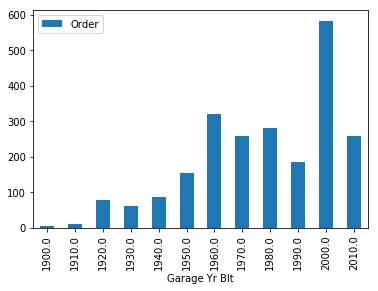

In [141]:
data[['Garage Yr Blt','Order']].groupby('Garage Yr Blt').count().plot(kind='bar')
plt.show()

In [142]:
# how to handle Nans? Use year build of house? or is there no garage? 
# Based on previous variable it could be related to having no Garage. Suggest to keep NaNs?
# data['Garage Yr Blt'].fillna(value=data['Year Built'],inplace=True)

### Garage Finish (Ordinal) - convert to numerical scale

In [143]:
print('Count NaNs:',data['Garage Finish'].isnull().sum())
data['Garage Finish'].unique()
# keep NaNs as is as per previous variable discussion

Count NaNs: 138


array(['Fin', 'Unf', 'RFn', nan], dtype=object)

In [144]:
data['Garage Finish'].replace({'Fin':3,'RFn':2,'Unf':1},inplace=True)
data_test['Garage Finish'].replace({'Fin':3,'RFn':2,'Unf':1},inplace=True)

### Garage Cars (Discrete) - clean

In [145]:
print('Count NaNs:',data['Garage Cars'].isnull().sum())
data['Garage Cars'].unique()
# keep NaNs as is as per previous variable discussion

Count NaNs: 1


array([ 2.,  1.,  3.,  0.,  4., nan])

In [146]:
data['Garage Cars'].fillna(value=0,inplace=True)
data_test['Garage Cars'].fillna(value=0,inplace=True) # handle test data

### Garage Area (Continuous)

In [147]:
print('Count NaNs:',data['Garage Area'].isnull().sum())
data['Garage Area'].fillna(value=0,inplace=True)
data_test['Garage Area'].fillna(value=0,inplace=True) # handle test data

Count NaNs: 1


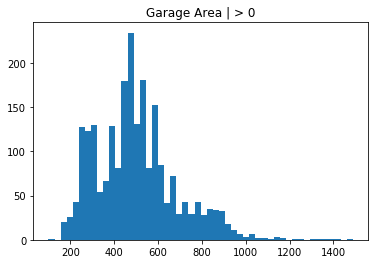

In [148]:
plt.hist(data[data['Garage Area'] > 0]['Garage Area'], bins=50)
plt.title('Garage Area | > 0')
plt.show()

In [149]:
mean_garage = data[data['Garage Area']>0]['Garage Area'].mean()
std_garage = data[data['Garage Area']>0]['Garage Area'].std()
data[((data['Garage Area'] != 0) & ((np.abs(data['Garage Area']-mean_garage) / std_garage) > 3))]['Garage Area']

71      1154.0
339     1134.0
473     1314.0
580     1166.0
600     1092.0
690     1138.0
1176    1488.0
1212    1231.0
1464    1110.0
1479    1390.0
1500    1418.0
1631    1248.0
1950    1069.0
1956    1348.0
2075    1085.0
2228    1356.0
2411    1174.0
Name: Garage Area, dtype: float64

In [150]:
outlier = ((data['Garage Area'] != 0) & ((np.abs(data['Garage Area']-mean_garage) / std_garage) > 3)) | outlier
outlier.sum()
# We now have 12 more outliers (80 - 68). Means there was some overlap (5 entries)

80

### Garage Qual & Garage Cond (Ordinal) - convert to numerical scale

In [151]:
print('Count NaNs:',data['Garage Qual'].isnull().sum())
data['Garage Qual'].unique()
# keep NaNs as is as per previous variables discussion

Count NaNs: 138


array(['TA', 'Fa', nan, 'Gd', 'Ex', 'Po'], dtype=object)

In [152]:
data['Garage Qual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
#data['Garage Qual'].fillna(value=0,inplace=True)
data_test['Garage Qual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
#data_test['Garage Qual'].fillna(value=0,inplace=True)

In [153]:
print('Count NaNs:',data['Garage Cond'].isnull().sum())
data['Garage Cond'].unique()
# keep NaNs as is as per previous variables discussion

Count NaNs: 138


array(['TA', nan, 'Fa', 'Gd', 'Ex', 'Po'], dtype=object)

In [154]:
data['Garage Cond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
#data['Garage Qual'].fillna(value=0,inplace=True)
data_test['Garage Cond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
#data_test['Garage Qual'].fillna(value=0,inplace=True)

### Paved Drive (Ordinal) - clean

In [155]:
print('Count NaNs:',data['Garage Cond'].isnull().sum())
data['Garage Cond'].unique()
# keep NaNs as is as per previous variables discussion
# keep as nominal instead of converting as different people may have different preferences on this. I don't see it as been ordinal

Count NaNs: 138


array([ 3., nan,  2.,  4.,  5.,  1.])

In [156]:
# handle test data
data_test['Garage Cond'].unique()

array([2, 3, nan, 4, 5], dtype=object)

### Wood Deck SF (Continous) - handle outliers

Count NaNs: 0


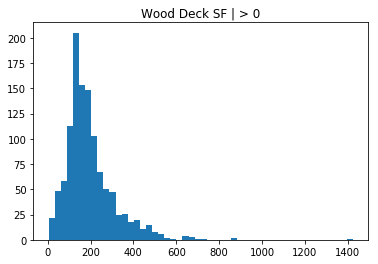

In [157]:
print('Count NaNs:',data['Wood Deck SF'].isnull().sum())
plt.hist(data[data['Wood Deck SF'] > 0]['Wood Deck SF'], bins=50)
plt.title('Wood Deck SF | > 0')
plt.show()

In [158]:
# Decided to consider values above 800 as outliers
outlier = (data['Wood Deck SF'] > 800) | outlier
outlier.sum()
# We now have 1 more outliers (81 - 80)

81

### Open Porch SF & Enclosed Porch & 3-Ssn & Screen Porch (Continuous) - handle outliers

Count NaNs: 0


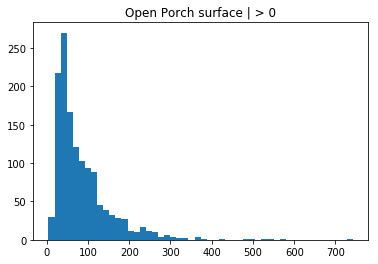

In [159]:
print('Count NaNs:',data['Open Porch SF'].isnull().sum())
plt.hist(data[data['Open Porch SF'] > 0]['Open Porch SF'], bins=50)
plt.title('Open Porch surface | > 0')
plt.show()

In [160]:
# Decided to consider values above 500 as outliers
outlier = (data['Open Porch SF'] > 500) | outlier
outlier.sum()
# We now have 5 more outliers (86 - 81)

86

Count NaNs: 0


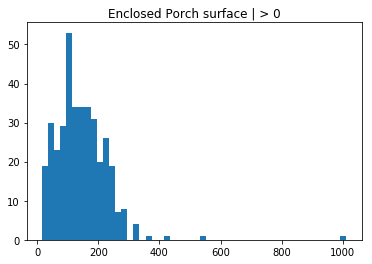

In [161]:
print('Count NaNs:',data['Enclosed Porch'].isnull().sum())
plt.hist(data[data['Enclosed Porch'] > 0]['Enclosed Porch'], bins=50)
plt.title('Enclosed Porch surface | > 0')
plt.show()

In [162]:
# Decided to consider values above 400 as outliers
outlier = (data['Enclosed Porch'] > 400) | outlier
outlier.sum()
# We now have 2 more outliers (88 - 86)

88

Count NaNs: 0


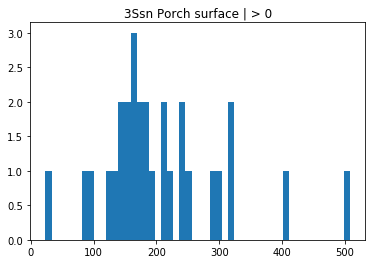

In [163]:
print('Count NaNs:',data['3Ssn Porch'].isnull().sum())
plt.hist(data[data['3Ssn Porch'] > 0]['3Ssn Porch'], bins=50)
plt.title('3Ssn Porch surface | > 0')
plt.show()
# Not considerung any outliers given the low number of data

Count NaNs: 0


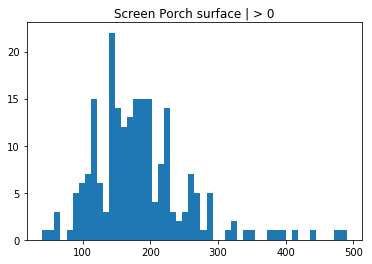

In [164]:
print('Count NaNs:',data['Screen Porch'].isnull().sum())
plt.hist(data[data['Screen Porch'] > 0]['Screen Porch'], bins=50)
plt.title('Screen Porch surface | > 0')
plt.show()
# Not considerung any outliers given the low number of data

### Pool Area (Continous) - clean

Count NaNs: 0


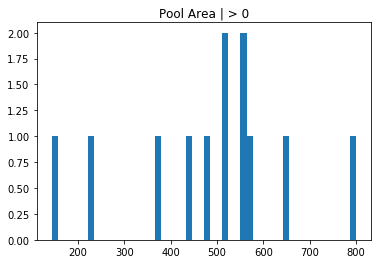

In [165]:
print('Count NaNs:',data['Pool Area'].isnull().sum())
plt.hist(data[data['Pool Area'] > 0]['Pool Area'], bins=50)
plt.title('Pool Area | > 0')
plt.show()
# Not considerung any outliers given the low number of data

### Pool QC (Ordinal) - convert to numerical scale

In [166]:
print('Count NaNs:',data['Pool QC'].isnull().sum())
data['Pool QC'].unique()

Count NaNs: 2418


array([nan, 'Fa', 'Ex', 'TA', 'Gd'], dtype=object)

In [167]:
data['Pool QC'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1},inplace=True)
data['Pool QC'].fillna(value=0,inplace=True)
data_test['Pool QC'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1},inplace=True)
data_test['Pool QC'].fillna(value=0,inplace=True)

### Fence (Ordinal) - convert to numerical scale

In [168]:
print('Count NaNs:',data['Fence'].isnull().sum())
data['Fence'].unique()

Count NaNs: 1941


array([nan, 'MnPrv', 'MnWw', 'GdPrv', 'GdWo'], dtype=object)

In [169]:
data['Fence'].replace({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1},inplace=True)
data['Fence'].fillna(value=0,inplace=True)
data_test['Fence'].replace({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1},inplace=True)
data_test['Fence'].fillna(value=0,inplace=True)

### Misc Feature (Nominal) - handle NaNs

In [170]:
print('Count NaNs:',data['Misc Feature'].isnull().sum())
data['Misc Feature'].unique()

Count NaNs: 2340


array([nan, 'Shed', 'Othr', 'Elev', 'Gar2', 'TenC'], dtype=object)

In [171]:
data['Misc Feature'].fillna(value='None',inplace=True)
data_test['Misc Feature'].fillna(value='None',inplace=True) # handle test data

### Misc Val (Continuous) - clean

Count NaNs: 0


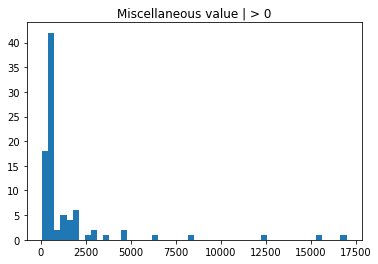

In [172]:
print('Count NaNs:',data['Misc Val'].isnull().sum())
plt.hist(data[data['Misc Val'] > 0]['Misc Val'], bins=50)
plt.title('Miscellaneous value | > 0')
plt.show()
# Not considerung any outliers given the low number of data

### Mo Sold & Yr Sold (Discrete) - clean

In [173]:
print('Count NaNs:',data['Mo Sold'].isnull().sum())
data['Mo Sold'].unique()

Count NaNs: 0


array([ 4,  6,  1,  5,  9,  3, 11,  2, 12,  7,  8, 10], dtype=int64)

In [174]:
data[['Mo Sold','Order']].groupby('Mo Sold').count()
# checking if distribution seems unbiased - seems ok

,Order
Mo Sold,
1,108
2,109
3,187
4,227
5,335
6,422
7,374
8,186
9,135


In [175]:
print('Count NaNs:',data['Yr Sold'].isnull().sum())
data['Yr Sold'].unique()

Count NaNs: 0


array([2009, 2006, 2007, 2010, 2008], dtype=int64)

In [176]:
data[['Yr Sold','Order']].groupby('Yr Sold').count()
# checking if distribution seems unbiased - seems ok

,Order
Yr Sold,
2006,514
2007,584
2008,530
2009,518
2010,284


### Sale Type & Sale Condition (Nominal) - clean

In [177]:
print('Count NaNs:',data['Sale Type'].isnull().sum())
data['Sale Type'].unique()

Count NaNs: 0


array(['WD ', 'New', 'ConLD', 'ConLI', 'CWD', 'COD', 'Oth', 'Con',
       'ConLw', 'VWD'], dtype=object)

In [178]:
print('Count NaNs:',data['Sale Condition'].isnull().sum())
data['Sale Condition'].unique()

Count NaNs: 0


array(['Normal', 'Family', 'Partial', 'Abnorml', 'Alloca', 'AdjLand'],
      dtype=object)

In [179]:
# handle test data
data_test['Sale Type'].unique()

array(['WD ', 'New', 'COD', 'ConLD', 'ConLw', 'CWD', 'ConLI', 'Oth'],
      dtype=object)

In [180]:
data_test['Sale Condition'].unique()

array(['Normal', 'Partial', 'Family', 'Abnorml', 'Alloca', 'AdjLand'],
      dtype=object)

### SalePrice (Continuous)

Count NaNs: 0


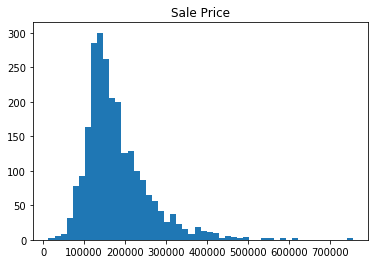

In [181]:
print('Count NaNs:',data['SalePrice'].isnull().sum())
plt.hist(data[data['SalePrice'] > 0]['SalePrice'], bins=50)
plt.title('Sale Price')
plt.show()
# Not considerung any outliers given the low number of data

In [182]:
print('Sale Price > 3 std:',(z_score(data['SalePrice']) > 3).sum())

Sale Price > 3 std: 36


In [183]:
data[z_score(data['SalePrice']) > 3]['SalePrice']
# all outliers are high prices

50      556581
102     745000
237     755000
321     615000
339     423000
386     457347
418     426000
503     479069
580     501837
647     475000
735     492000
838     584500
854     421250
1102    466500
1143    455000
1191    468000
1201    552000
1213    610000
1387    451950
1464    591587
1519    611657
1588    445000
1686    470000
1696    462000
1724    545224
1759    425000
1760    437154
1843    500000
1956    475000
2142    582933
2163    446261
2285    535000
2335    440000
2372    441929
2393    555000
2411    500067
Name: SalePrice, dtype: int64

In [184]:
# Decided to tag as outliers values above 3 std away from mean
outlier = (z_score(data['SalePrice']) > 3) | outlier
outlier.sum()
# We now have 18 more outliers (104 - 88)

104

### Identifying data removed as considered as outlier

As we some while working on each variable we tend to consider as outliers high values as usually lower limit is 0. Is this a correct way of doing it? Looking at the scatter plot it seems we would be able to predict correctly with the data points available.

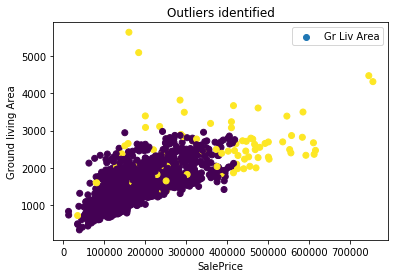

In [185]:
plt.scatter('SalePrice','Gr Liv Area',data=data,c=outlier)
plt.xlabel('SalePrice')
plt.ylabel('Ground living Area')
plt.title('Outliers identified')
plt.legend()
plt.show()
# how to show two colors for True and False outliers in legend?

## (C) Feature engineering

*Feature engineering technics*
* Applying transformations - log,sqrt, poly
* Create indicator variables
* Combine numerical variable
* Combine binary variable
* other functions

### (i) Applying transformations (log)

In [186]:
import seaborn as sns
from scipy.stats import norm

In [187]:
# Copy data set to create data engineered
data_eng = data.copy()

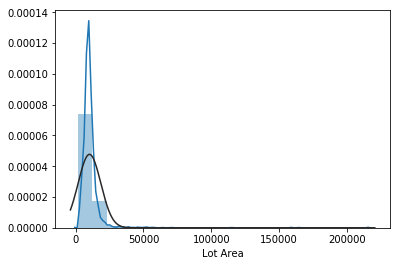

In [188]:
sns.distplot(data['Lot Area'], bins=20, fit=norm)
plt.show()

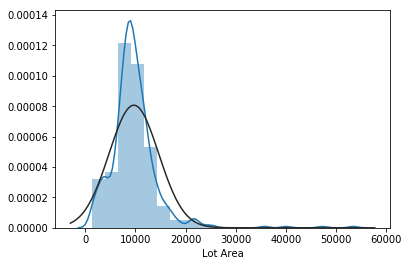

In [189]:
sns.distplot(data_test['Lot Area'], bins=20, fit=norm)
plt.show()

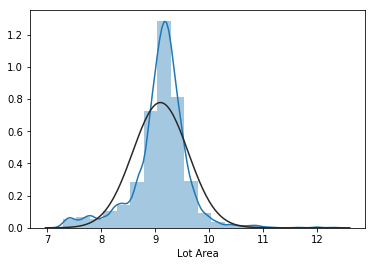

In [190]:
sns.distplot(np.log(data['Lot Area']), bins=20, fit=norm)
plt.show()

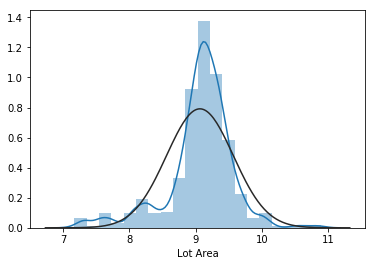

In [191]:
sns.distplot(np.log(data_test['Lot Area']), bins=20, fit=norm)
plt.show()

In [192]:
# Apply logarithmic transformation to Lot Area to remove skewed distribution
data_eng['Lot Area'] = np.log(data_eng['Lot Area'])
data_test['Lot Area'] = np.log(data_test['Lot Area']) # handle test data

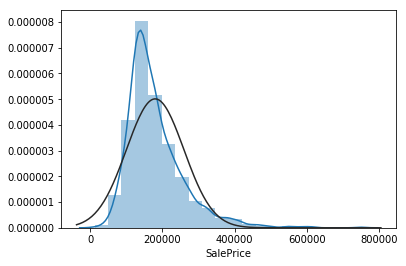

In [193]:
sns.distplot(data['SalePrice'], bins=20, fit=norm)
plt.show()

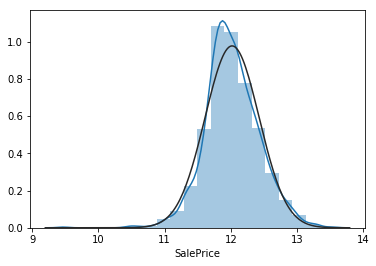

In [194]:
sns.distplot(np.log(data['SalePrice']), bins=20, fit=norm)
plt.show()

In [195]:
# Decided not to apply log transformation at this stage to SalePrice as when removing outliers had already a positive effect on distribution. Log applied later.

### (ii) Create indicator variable

In [196]:
# Create indicator to define if house was built or remod in last 10 years => NEW
data_eng['New or remod'] = ((data_eng['Year Built'] >= 2010) | (data_eng['Year Remod/Add'] >= 2010))*1
data_eng['New or remod'] = data_eng['New or remod'].map({0:'old',1:'new'})
# handle test data
data_test['New or remod'] = ((data_test['Year Built'] >= 2010) | (data_test['Year Remod/Add'] >= 2010))*1
data_test['New or remod'] = data_test['New or remod'].map({0:'old',1:'new'})

In [197]:
# Create indicator to count number of "positive conditions" - (between 0 and 2)
data_eng['Condition Count'] = np.max(data_eng['Condition 1'] != 'Norm')*1 + (data_eng['Condition 2'] != 'Norm')*1
# handle test data
data_test['Condition Count'] = np.max(data_test['Condition 1'] != 'Norm')*1 + (data_test['Condition 2'] != 'Norm')*1

### (iii) Combine numerical variable

In [198]:
# Sum number of baths and remove both current fields as believe it does't make major difference if Bath in Basement or not
data_eng['Bath'] = data_eng['Bsmt Full Bath'] + data_eng['Full Bath'] + data_eng['Bsmt Half Bath']/2 + data_eng['Half Bath']/2
data_eng.drop(columns=['Bsmt Full Bath','Full Bath','Bsmt Half Bath','Half Bath'],inplace=True)

# handle test data
data_test['Bath'] = data_test['Bsmt Full Bath'] + data_test['Full Bath'] + data_test['Bsmt Half Bath']/2 + data_test['Half Bath']/2
data_test.drop(columns=['Bsmt Full Bath','Full Bath','Bsmt Half Bath','Half Bath'],inplace=True)

In [199]:
# Sum total floor surface and remove two indiviual variables
data_eng['Flr SF'] = data_eng['1st Flr SF'] + data_eng['2nd Flr SF']
data_eng.drop(columns=['1st Flr SF','2nd Flr SF'],inplace=True)
# In addition apply polynomial featuring
#data_eng['Flr SF deg2'] = data_eng['Flr SF']**2
#data_eng['Flr SF deg3'] = data_eng['Flr SF']**3

# handle test data
data_test['Flr SF'] = data_test['1st Flr SF'] + data_test['2nd Flr SF']
data_test.drop(columns=['1st Flr SF','2nd Flr SF'],inplace=True)

## (B) Feature encoding

### One-hot encoding - Nominal variable and Ordinal variable which haven't been converted to numerical scale

In [200]:
# Nominal variables + Ordinal variable not converted to numerical scale
data_encoded_nom = pd.get_dummies(data_eng, columns=['MS SubClass','MS Zoning','Street','Alley','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Misc Feature','Sale Type','Sale Condition','Roof Style','New or remod'], drop_first=True)
data_encoded_ord = pd.get_dummies(data_encoded_nom, columns=['Lot Shape','Land Slope','Electrical','Paved Drive'], drop_first=True)
data_encoded_disc = pd.get_dummies(data_encoded_ord, columns=['Year Built','Year Remod/Add','Garage Yr Blt','Mo Sold','Yr Sold'], drop_first=True)
data_preprocessed = data_encoded_disc

# handle test data
data_test = pd.get_dummies(data_test, columns=['MS SubClass','MS Zoning','Street','Alley','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Misc Feature','Sale Type','Sale Condition','Roof Style','New or remod'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['Lot Shape','Land Slope','Electrical','Paved Drive'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['Year Built','Year Remod/Add','Garage Yr Blt','Mo Sold','Yr Sold'], drop_first=True)
data_test = data_test

In [201]:
print('# columns after nominal encoding:',data_encoded_nom.shape[1])
print('# columns after ordinal encoding:',data_encoded_ord.shape[1])
print('# columns after nominal discrete:',data_encoded_disc.shape[1])

# columns after nominal encoding: 222
# columns after ordinal encoding: 227
# columns after nominal discrete: 267


In [202]:
pd.set_option('display.max_columns', None)
data_preprocessed.head()

,Order,PID,Lot Frontage,Lot Area,Utilities,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,SalePrice,Condition Count,Bath,Flr SF,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_No access,Alley_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_PreCast,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Misc Feature_Gar2,Misc Feature_None,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,New or remod_old,Lot Shape_Reg,Land Slope_Mod,Land Slope_Sev,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Paved Drive_P,Paved Drive_Y,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2000,Year Built_2010,Year Remod/Add_1960.0,Year Remod/Add_1970.0,Year Remod/Add_1980.0,Year Remod/Add_1990.0,Year R

In [203]:
#(np.isnan(data_preprocessed.any())).sum() #and gets False
np.isfinite(data_preprocessed.all()) #and gets True

Order                    True
PID                      True
Lot Frontage             True
Lot Area                 True
Utilities                True
Overall Qual             True
Overall Cond             True
Mas Vnr Area             True
Exter Qual               True
Exter Cond               True
Bsmt Qual                True
Bsmt Cond                True
Bsmt Exposure            True
BsmtFin Type 1           True
BsmtFin SF 1             True
BsmtFin Type 2           True
BsmtFin SF 2             True
Bsmt Unf SF              True
Total Bsmt SF            True
Heating QC               True
Low Qual Fin SF          True
Gr Liv Area              True
Bedroom AbvGr            True
Kitchen AbvGr            True
Kitchen Qual             True
TotRms AbvGrd            True
Functional               True
Fireplaces               True
Fireplace Qu             True
Garage Finish            True
                         ... 
Year Remod/Add_1980.0    True
Year Remod/Add_1990.0    True
Year Remod

## (D) Model fitting

### (i) Simple Model and baseline

* Decided to select continuous variable with the highest correlation to output variable
* Instinctively I would have gone for 'Lot Area' but data show it would be 'Flr SF' (which also makes business sense)

**Note:** also testing impact of different share of split for test group with loop. 20% in test seems a good compromise (see line graph at end of section)

In [204]:
# removing identified outliers
data_final = data_preprocessed[~outlier]

In [205]:
#data_preprocessed.corr()[['SalePrice']].sort_values(by="SalePrice",ascending=False).head()

In [206]:
data_final.corr()[['SalePrice']].sort_values(by="SalePrice",ascending=False).head()

,SalePrice
SalePrice,1.000000
Overall Qual,0.811812
Flr SF,0.698397
Gr Liv Area,0.692258
Kitchen Qual,0.665684


In [207]:
data_final[['Overall Qual','Flr SF','Gr Liv Area','Kitchen Qual']].head(10)

,Overall Qual,Flr SF,Gr Liv Area,Kitchen Qual
0,7,2256,2256,4
1,6,1575,1575,4
2,4,1092,1092,3
3,5,1700,1700,4
4,7,1889,1889,3
5,5,1159,1159,3
6,4,1328,1328,3
7,5,1749,1869,3
8,8,1801,1801,4
9,6,1199,1199,4


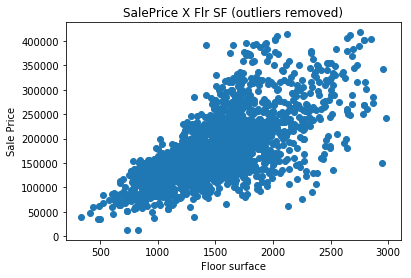

In [208]:
plt.scatter(data_final['Flr SF'],data_final['SalePrice'])
plt.xlabel('Floor surface')
plt.ylabel('Sale Price')
plt.title('SalePrice X Flr SF (outliers removed)')
plt.show()

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

In [210]:
# start by splitting train and test sets
# Create X, y
X = data_final['Flr SF'].values
y = np.log10(data_final.SalePrice.values)
#y = data_final.SalePrice.values

# Split into train/test sets
# test difference splits
test = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
z1 = []
z2 = []
for t in test:
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size = t, train_size = (1-t), random_state=0)
    
    #print('Train:', X_train.shape, y_train.shape)
    #print('Test:', X_test.shape, y_test.shape)

    # Try with a linear regression
    coef = np.polyfit(X_train_s,y_train_s,deg=1)
    #x_values = np.linspace(x.min(),x.max(),n=100)
    y_pred_test_s = np.polyval(coef,X_test_s)
    #y_base_test = np.median(y_train)

    #print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))),'split:',t)
    #print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))),'test split:',t)
    print('Test_split:',t,' | ', 'MAE: {:.0f}'.format(MAE(10**y_test_s, 10**y_pred_test_s)),' | ',\
          'R2: {:.2f}'.format(1 - MAE(y_test_s, y_pred_test_s)/np.mean(np.abs(y_test_s - np.median(y_train_s)))))
    #print('Test MAE: {:.0f}'.format(MAE(y_test, y_pred_test)))
    z1.append(MAE(10**y_test_s, 10**y_pred_test_s))
    z2.append(np.mean(np.abs(10**y_test_s - np.median(10**y_train_s))))
    #print('R2: {:.2f}'.format(1 - MAE(y_test, y_pred_test)/np.mean(np.abs(y_test - np.median(y_train)))))

Test_split: 0.1  |  MAE: 30766  |  R2: 0.33
Test_split: 0.2  |  MAE: 31636  |  R2: 0.30
Test_split: 0.3  |  MAE: 33648  |  R2: 0.29
Test_split: 0.4  |  MAE: 34236  |  R2: 0.29
Test_split: 0.5  |  MAE: 34068  |  R2: 0.30
Test_split: 0.6  |  MAE: 34280  |  R2: 0.30
Test_split: 0.7  |  MAE: 34075  |  R2: 0.31
Test_split: 0.8  |  MAE: 35001  |  R2: 0.31
Test_split: 0.9  |  MAE: 35505  |  R2: 0.30


In [211]:
#MAE(y_test,np.median(y_train))
# getting error using MAE function

Base on findings will go with 0.2 test_split as seems to be an inflection point


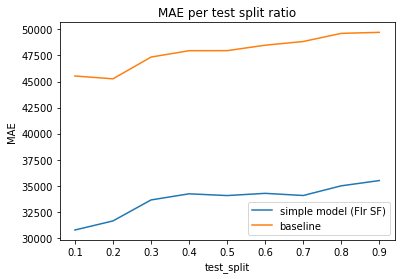

In [212]:
print('Base on findings will go with 0.2 test_split as seems to be an inflection point')
plt.plot(test,z1, label='simple model (Flr SF)')
plt.plot(test,z2, label='baseline')
plt.title('MAE per test split ratio')
plt.ylabel('MAE')
plt.xlabel('test_split')
plt.legend()
plt.show()

In [213]:
# start by splitting train and test sets
# Create X, y
X = data_final['Flr SF'].values
y = np.log10(data_final.SalePrice.values)
#y = data_final.SalePrice.values

# Split into train/test sets
# test difference splits
test = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size = t, train_size = (1-t), random_state=0)

coef = np.polyfit(X_train_s,y_train_s,deg=1)
y_pred_test_s = np.polyval(coef,X_test_s)

print('Test_split:',t,' | ', 'MAE: {:.0f}'.format(MAE(10**y_test_s, 10**y_pred_test_s)),' | ',\
          'R2: {:.2f}'.format(1 - MAE(y_test_s, y_pred_test_s)/np.mean(np.abs(y_test_s - np.median(y_train_s)))))

Test_split: 0.9  |  MAE: 35505  |  R2: 0.30


In [214]:
coef_test = coef

In [215]:
mae_simple = round(z1[1],0)
mae_base = round(z2[1],0)
print('Simple model MAE:',mae_simple)
print('Base model MAE:',mae_base)

Simple model MAE: 31636.0
Base model MAE: 45259.0


### (ii) Intermediate model

* Need to do some additional data cleaning on 3 variable which still have 'NaN' which are cresting error when computing model
* Also using list of columns in scope for a more efficient a re-usable (not hardcoded) code

In [216]:
# identifying columns with NULL values
data_final.isnull().sum().to_frame().sort_values(by=0, ascending=False).head()

,0
Garage Cond,134
Garage Qual,134
Garage Finish,134
Order,0
Heating_GasA,0


In [217]:
# Replacing 'NaN' with 0
print(data_final['Garage Finish'].unique())
data_final['Garage Finish'].fillna(value=0,inplace=True)
data_test['Garage Finish'].fillna(value=0,inplace=True) # handle test data

[ 3.  1.  2. nan]


C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [218]:
# Replacing 'NaN' with 0
print(data_final['Garage Cond'].unique())
data_final['Garage Cond'].fillna(value=0,inplace=True)
data_test['Garage Cond'].fillna(value=0,inplace=True) # handle test data

[ 3. nan  2.  4.  5.  1.]


In [219]:
# Replacing 'NaN' with 0
print(data_final['Garage Qual'].unique())
data_final['Garage Qual'].fillna(value=0,inplace=True)
data_test['Garage Qual'].fillna(value=0,inplace=True) # handle test data

[ 3.  2. nan  5.  4.  1.]


In [220]:
# List of 20 most correlated columns
data_final.corr()[['SalePrice']].drop('SalePrice').sort_values(by="SalePrice",ascending=False).head(20)

,SalePrice
Overall Qual,0.811812
Flr SF,0.698397
Gr Liv Area,0.692258
Kitchen Qual,0.665684
Garage Cars,0.660251
Garage Area,0.639482
Bath,0.631609
Total Bsmt SF,0.625832
Bsmt Qual,0.614662
Garage Finish,0.586231


In [221]:
# Creating list of 20 most correlated columns
print(data_final.corr()[['SalePrice']].drop('SalePrice').sort_values(by="SalePrice",ascending=False).head(20).index.values)
columns_int_model = data_final.corr()[['SalePrice']].drop('SalePrice').sort_values(by="SalePrice",ascending=False).head(20).index.values.tolist()

['Overall Qual' 'Flr SF' 'Gr Liv Area' 'Kitchen Qual' 'Garage Cars'
 'Garage Area' 'Bath' 'Total Bsmt SF' 'Bsmt Qual' 'Garage Finish'
 'Foundation_PConc' 'Fireplace Qu' 'Heating QC' 'Fireplaces'
 'TotRms AbvGrd' 'Mas Vnr Area' 'Garage Type_Attchd'
 'Garage Yr Blt_2010.0' 'Year Built_2000' 'Neighborhood_NridgHt']


In [222]:
# merging both lists
print(data_final.filter(regex='Garage Yr|Garage Type|Year Built|Neighborhood').columns)
columns_int_model.extend(data_final.filter(regex='Garage Yr|Garage Type|Year Built|Neighborhood').columns)

Index(['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
       'Garage Type_Attchd', 'Garage Type_Basment', 'Garage Type_BuiltIn',
       'Garage Type_CarPort', 'Garage Type_Detchd', 'Garage Type_No Garage',
       'Year Built_1890', 'Year Built_1900', 'Year Built_1910',
       'Year Built_1920', 'Year Built_1930', 'Year Built_1940',
       'Year Built_

In [223]:
# removing the duplicates
columns_int_model_clean = list(dict.fromkeys(columns_int_model))

In [224]:
data_final[columns_int_model_clean].head()

,Overall Qual,Flr SF,Gr Liv Area,Kitchen Qual,Garage Cars,Garage Area,Bath,Total Bsmt SF,Bsmt Qual,Garage Finish,Foundation_PConc,Fireplace Qu,Heating QC,Fireplaces,TotRms AbvGrd,Mas Vnr Area,Garage Type_Attchd,Garage Yr Blt_2010.0,Year Built_2000,Neighborhood_NridgHt,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2010,Garage Yr Blt_1910.0,Garage Yr Blt_1920.0,Garage Yr Blt_1930.0,Garage Yr Blt_1940.0,Garage Yr Blt_1950.0,Garage Yr Blt_1960.0,Garage Yr Blt_1970.0,Garage Yr Blt_1980.0,Garage Yr Blt_1990.0,Garage Yr Blt_2000.0
0,7,2256,2256,4,2.0,554.0,2.5,952.0,4.0,3.0,1,3.0,5,1,8,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,6,1575,1575,4,2.0,400.0,1.5,216.0,3.0,1.0,0,4.0,3,1,5,522.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,4,1092,1092,3,1.0,286.0,1.5,546.0,3.0,1.0,0,0.0,2,0,6,80.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,5,1700,1700,4,2.0,447.0,2.0,1398.0,3.0,2.0,0,4.0,4,1,6,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,7,1889,1889,3,1.0,308.0,1.5,925.0,3.0,1.0,0,4.0,3,1,9,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [225]:
#data_final[data_final.filter(regex='Garage Yr|Garage Type|Year Built').columns]

In [226]:
# start by splitting train and test sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

# Create X, y
X = data_final[columns_int_model_clean].values
y = np.log10(data_final.SalePrice).values
#y = data_final.SalePrice.values

# Split into train/test sets
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state=0)

#print('Train:', X_train.shape, y_train.shape)
#print('Test:', X_test.shape, y_test.shape)

# Try with a linear regression
lr_int = LinearRegression()
lr_int.fit(X_train_i, y_train_i)

#print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))),'split:',t)
#print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))),'test split:',t)
print('Train MAE: {:.0f}'.format(MAE(10**y_train_i, 10**lr_int.predict(X_train_i))))
print('Test MAE: {:.0f}'.format(MAE(10**y_test_i, 10**lr_int.predict(X_test_i))))

Train MAE: 14660
Test MAE: 15542


In [227]:
mae_intermediate = round(MAE(10**y_test_i, 10**lr_int.predict(X_test_i)),0)
print('Intermediate model MAE:',mae_intermediate)
print('Simple model MAE:',mae_simple)
print('Base model MAE:',mae_base)

Intermediate model MAE: 15542.0
Simple model MAE: 31636.0
Base model MAE: 45259.0


### (iii) Complex model

In [228]:
# start by splitting train and test sets
from sklearn.model_selection import train_test_split

# Create X, y
X = data_final.drop(['SalePrice','PID'], axis=1).values
y = np.log10(data_final.SalePrice).values
#y = data_final.SalePrice.values

# Split into train/test sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state=0)

print('Train:', X_train_c.shape, y_train_c.shape)
print('Test:', X_test_c.shape, y_test_c.shape)

Train: (1860, 265) (1860,)
Test: (466, 265) (466,)


In [229]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

# Try with a linear regression
lr = LinearRegression()
lr.fit(X_train_c, y_train_c)

#print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))))
#print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))))
#print('Train MAE: {:.0f}'.format(MAE(y_train_c, lr.predict(X_train_c))))
#print('Test MAE: {:.0f}'.format(MAE(y_test_c, lr.predict(X_test_c))))

# below prints when using log
print('Train MAE (log): {:.0f}'.format(MAE(10**y_train_c, 10**lr.predict(X_train_c))))
print('Test MAE (log): {:.0f}'.format(MAE(10**y_test_c, 10**lr.predict(X_test_c))))

Train MAE (log): 10672
Test MAE (log): 11694


In [230]:
mae_complex_lr = round(MAE(10**y_test_c, 10**lr.predict(X_test_c)),0)
print('Complex lr model MAE:',mae_complex_lr)
print('Intermediate lr model MAE:',mae_intermediate)
print('Simple lr model MAE:',mae_simple)
print('Base model MAE:',mae_base)

Complex lr model MAE: 11694.0
Intermediate lr model MAE: 15542.0
Simple lr model MAE: 31636.0
Base model MAE: 45259.0


### Lasso regression

In [231]:
# tried with Lasso which is supposed to better optimized MAE function but get to much higher results
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1,max_iter=10000)
lasso.fit(X_train_c, y_train_c)

#print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))))
#print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))))
print('Train Lasso MAE: {:.0f}'.format(MAE(10**y_train_c, 10**lasso.predict(X_train_c))))
print('Test Lasso MAE: {:.0f}'.format(MAE(10**y_test_c, 10**lasso.predict(X_test_c))))

Train Lasso MAE: 24735
Test Lasso MAE: 23351


### Ridge regression

Let's first create the list of  𝑎𝑙𝑝ℎ𝑎  values and evaluate a ridge regression model for each one. Regularization strength affects the generization error on a log-scale. So we will use  𝑛𝑝.𝑙𝑜𝑔𝑠𝑝𝑎𝑐𝑒(𝑎,𝑏)  to generate sample  𝑎𝑙𝑝ℎ𝑎  values i.e. instead of  𝑛𝑝.𝑙𝑖𝑛𝑠𝑝𝑎𝑐𝑒(𝑎,𝑏) .

*It's frequent to start with a range between  𝑎=1𝑒−4  and  𝑏=1𝑒4  for this hyperparameter, but we will use a larger range this time to see the effect of regularization with very large/small values.*

In [232]:
from sklearn.linear_model import Ridge
# Try with a linear regression
ridge = Ridge()
ridge.fit(X_train_c, y_train_c)

#print('Train MSE: {:.4f}'.format(MSE(y_train, lr.predict(X_train))))
#print('Test MSE: {:.4f}'.format(MSE(y_test, lr.predict(X_test))))
print('Train Ridge MAE: {:.0f}'.format(MAE(10**y_train_c, 10**ridge.predict(X_train_c))))
print('Test Ridge MAE: {:.0f}'.format(MAE(10**y_test_c, 10**ridge.predict(X_test_c))))

Train Ridge MAE: 10919
Test Ridge MAE: 11903


### Grid search

In [233]:
# standardize data
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train_c)
X_test_rescaled = scaler.transform(X_test_c)

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [234]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-10, 10, num=100):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_rescaled, y_train_c)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mse': MSE(y_train_c, ridge.predict(X_train_rescaled)),
        'train_mae': MAE(10**y_train_c, 10**ridge.predict(X_train_rescaled)),
        'test_mse': MSE(y_test_c, ridge.predict(X_test_rescaled)),
        'test_mae': MAE(10**y_test_c, 10**ridge.predict(X_test_rescaled)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,test_mae,test_mse,train_mae,train_mse
0,1.000000e-10,11694.417096,0.003199,10672.030593,0.001589
1,1.592283e-10,11694.371047,0.003199,10672.030593,0.001589
2,2.535364e-10,11694.349318,0.003199,10672.030593,0.001589
3,4.037017e-10,11694.361272,0.003199,10672.030593,0.001589
4,6.428073e-10,11694.366983,0.003199,10672.030593,0.001589


### Validation curves

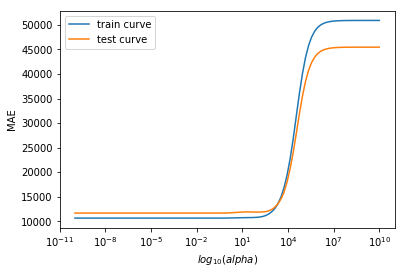

In [235]:
# Plot the validation curves
plt.semilogx(gs_results['alpha'], gs_results['train_mae'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mae'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [236]:
#Let's retrieve the alpha with the best generalization i.e. the one that minimizes the test score.

# Get entry with the best test MSE
best_result = gs_results.loc[gs_results.test_mse.idxmin()]

# Print the details
print('Best alpha: {:.1e}'.format(best_result.alpha))
print('Test MSE: {:.4f}'.format(best_result.test_mse))
print('Test MAE: {:,.0f}$'.format(best_result.test_mae))

Best alpha: 1.3e+00
Test MSE: 0.0032
Test MAE: 11,741$


In [237]:
mae_complex_ridge = round(best_result.test_mae,0)
print('Complex Ridge model MAE:',mae_complex_ridge)
print('Complex lr model MAE:',mae_complex_lr)
print('Intermediate lr model MAE:',mae_intermediate)
print('Simple lr model MAE:',mae_simple)
print('Base model MAE:',mae_base)

Complex Ridge model MAE: 11741.0
Complex lr model MAE: 11694.0
Intermediate lr model MAE: 15542.0
Simple lr model MAE: 31636.0
Base model MAE: 45259.0


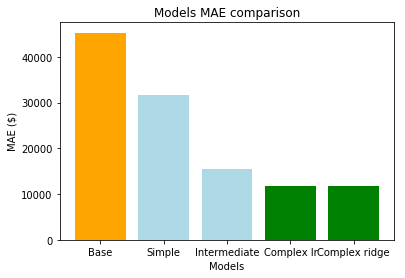

In [238]:
plt.bar(x=['Base','Simple','Intermediate','Complex lr','Complex ridge'],height=[mae_base,mae_simple,mae_intermediate,mae_complex_lr,mae_complex_ridge],color=['orange','lightblue','lightblue','green','green'])
plt.title('Models MAE comparison')
plt.ylabel('MAE ($)')
plt.xlabel('Models')
plt.show()

# Results

### Communicate

Both complex models are over-performing the Base/Simple/Intermdiate models:
* However Intermedia model with 20 variable is already getting pretty decent results with +- 15.5K dollars from house price on average
* Complex models are both perdicting house prices +- 11.6K dollars

Would it make sense to go with the Intermdiate model in this scenario? Based on Occam's razor we shouldn't go for over-complex models if there is not important added value

### Compute

In [239]:
data_test.head()

,Order,PID,Lot Frontage,Lot Area,Utilities,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Condition Count,Bath,Flr SF,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_No access,Alley_Pave,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosN,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Other,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No Garage,Misc Feature_Othr,Misc Feature_Shed,Sale Type_CWD,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,New or remod_old,Lot Shape_Reg,Land Slope_Mod,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Paved Drive_P,Paved Drive_Y,Year Built_1880,Year Built_1890,Year Built_1900,Year Built_1910,Year Built_1920,Year Built_1930,Year Built_1940,Year Built_1950,Year Built_1960,Year Built_1970,Year Built_1980,Year Built_1990,Year Built_2000,Year Built_2010,Year Remod/Add_1960.0,Year Remod/Add_1970.0,Year Remod/Add_1980.0,Year Remod/Add_1990.0,Year Remod/Add_2000.0,Year Remod/Add_2010.0,Garage Yr Blt_1910.0,Garage Yr Blt_1920.0,Garage Yr Blt_1930.0,Garage Yr Blt_1940.0,Garage Yr Blt_1950.0,Garage Yr Blt_1960.0,Garage Yr Blt_1970.0,Garage Yr Blt_1980.0,Garage Yr Blt_1990.0,Garage Yr Blt_2000.0,Garage Yr Blt_2010.0,Mo Sold_2,Mo Sold_3,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Mo Sold_10,Mo Sold_11,Mo Sold_12,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010
0,2217,909279080,69.20199,9.330343,5,6,7,480.0,3,3,3.0,3.0,2.0,3.0,297.0,2.0,557.0,0.0,854.0,3,0,1991,3,1,3,7,8,1,4.0,1.0,2.0,432.0,3,2,0,

In [240]:
# simple model
X_test_simple = data_test['Flr SF']
data_test['pred_simple'] = np.round(10**np.polyval(coef_test,X_test_simple),0)

In [241]:
data_test['Neighborhood_Greens'] = 0
data_test['Neighborhood_GrnHill'] = 0
data_test['Neighborhood_Landmrk'] = 0

In [242]:
# create columns with 0 instead
#columns_int_model_clean.remove('Neighborhood_Greens')
#columns_int_model_clean.remove('Neighborhood_GrnHill')
#columns_int_model_clean.remove('Neighborhood_Landmrk')
X_test_int = data_test[columns_int_model_clean].values

In [243]:
# intermediate model
data_test['pred_int'] = np.round(10**lr_int.predict(X_test_int),0)
data_test[['Order','PID','pred_simple','pred_int']].head()

,Order,PID,pred_simple,pred_int
0,2217,909279080,230491.0,166914.0
1,837,907126050,120626.0,137245.0
2,2397,528144030,227381.0,277060.0
3,1963,535452060,132403.0,129548.0
4,306,911202100,136225.0,88047.0


In [244]:
# complex model => some columns missing in data_test

In [245]:
print('Shape test:',data_test.shape)
print('Shape final:',data_final.shape)

Shape test: (500, 240)
Shape final: (2326, 267)


In [246]:
test_list = data_test.drop(columns=['pred_simple','pred_int']).columns.tolist()
train_list = data_final.columns.tolist()

In [247]:
# remove columns which are in test list but not in initial data used to fit LinearRegression
to_drop = []
for x in test_list:
    if x in train_list: continue
    else:
        print(x)
        to_drop.append(x)
data_test.drop(columns=to_drop,inplace=True)

Roof Matl_Roll
Exterior 2nd_Other
Year Built_1880


In [248]:
# add variables which are in data used to fit LinearRegression but not in test sample
for x in train_list:
    if x in test_list: continue
    else:
        print(x)
        data_test[x] = 0

SalePrice
MS SubClass_150
MS Zoning_C (all)
MS Zoning_I (all)
Condition 2_Feedr
Condition 2_PosA
Condition 2_RRAe
Condition 2_RRAn
Condition 2_RRNn
Roof Matl_CompShg
Roof Matl_Membran
Roof Matl_Metal
Roof Matl_WdShngl
Exterior 1st_AsphShn
Exterior 1st_BrkComm
Exterior 1st_CBlock
Exterior 1st_ImStucc
Exterior 1st_PreCast
Exterior 1st_Stone
Exterior 2nd_AsphShn
Exterior 2nd_PreCast
Mas Vnr Type_CBlock
Foundation_Wood
Heating_GasA
Misc Feature_Gar2
Misc Feature_None
Misc Feature_TenC
Sale Type_Con
Sale Type_VWD
Roof Style_Shed
Land Slope_Sev
Electrical_Mix


In [249]:
print('Shape test:',data_test.shape)
print('Shape final:',data_final.shape)

Shape test: (500, 269)
Shape final: (2326, 267)


In [250]:
X_test_complex = data_test.drop(columns=['SalePrice','pred_simple','pred_int','PID']).values
data_test['pred_complex'] = np.round(10**lr.predict(X_test_complex),0)

In [251]:
X_test_c

array([[263, 68.0, 8.919988070968524, ..., 0, 0, 1],
       [1031, 80.0, 9.257223957875032, ..., 1, 0, 0],
       [2194, 60.0, 9.010669176847115, ..., 0, 0, 0],
       ...,
       [1288, 80.0, 8.476371196895983, ..., 1, 0, 0],
       [1646, 78.0, 9.400133943608838, ..., 0, 0, 0],
       [1150, 70.0, 9.116029692504942, ..., 1, 0, 0]], dtype=object)

In [252]:
lr.score(X,y)

0.9299475560031472

In [253]:
10**lr.predict(X_test_complex)

array([ 3246009.99290708,  2958138.26006762,  3211856.59463418,
        4192276.54335245,   546479.37503011,  3847268.18968743,
         406350.15085191,  2488928.77027231,  3795001.6514822 ,
        3019579.07761673,  4454897.93620023,  3189645.74947916,
        6444800.93141445,  1599505.38636637,  1080391.52294465,
        2842245.47277251,   518135.28737593,  2073029.92749322,
        4000571.44966828,  2442200.35751275,   813694.55602751,
        4668476.35032149,  4218435.33326747,  2363855.61822564,
        2409679.24789661,  2653075.40341193,  4014629.09116943,
        3118593.59394748,   762924.58444422,  4835656.62317382,
        4188340.92770287,  5988900.94016485,  2508404.24867183,
        2022739.40758795,  2647131.56230116,  1266945.01350595,
        3671332.25901588,   504393.84808511,  7508903.19159764,
        3925215.38061196,  2933786.89206487,  3033512.62389516,
        1709964.82893517,  5435824.77325916,  5881649.88977431,
        6333928.71179383,  3789452.62262

In [254]:
data_test[['PID','pred_simple','pred_int','pred_complex']].head(10)

,PID,pred_simple,pred_int,pred_complex
0,909279080,230491.0,166914.0,3246010.0
1,907126050,120626.0,137245.0,2958138.0
2,528144030,227381.0,277060.0,3211857.0
3,535452060,132403.0,129548.0,4192277.0
4,911202100,136225.0,88047.0,546479.0
5,531382090,180027.0,171583.0,3847268.0
6,902477130,106469.0,60124.0,406350.0
7,527402150,119926.0,137591.0,2488929.0
8,908102320,164122.0,149734.0,3795002.0
9,908276140,138536.0,104009.0,3019579.0


In [255]:
data_test[['PID','pred_simple']].rename(columns={'pred_simple':'SalePrice'}).to_csv(r'house-price\predictions-simple-model.csv',index=False)
data_test[['PID','pred_int']].rename(columns={'pred_int':'SalePrice'}).to_csv(r'house-price\predictions-intermediate-model.csv',index=False)
data_test[['PID','pred_complex']].rename(columns={'pred_complex':'SalePrice'}).to_csv(r'house-price\predictions-complex-model.csv',index=False)
data_test[['PID','pred_simple','pred_int','pred_complex']].to_csv(r'house-price\predictions-all-model.csv',index=False)

In [256]:
((data_final.median() - data_test.median()) / data_final.median()).to_frame().sort_values(by=0,ascending=False).head(10)

,0
Heating_GasA,1.000000e+00
House Style_1Story,1.000000e+00
Misc Feature_None,1.000000e+00
SalePrice,1.000000e+00
Roof Matl_CompShg,1.000000e+00
BsmtFin SF 1,4.861111e-02
Order,3.452991e-02
Lot Area,1.961288e-03
PID,5.313228e-06
Lot Frontage,2.053533e-16


69.20199004975125


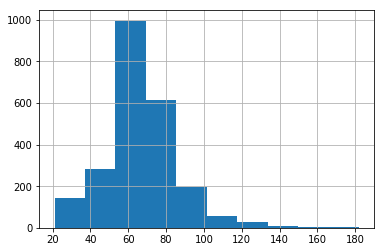

In [257]:
data_final['Lot Frontage'].hist()
print(data_final['Lot Frontage'].median())
plt.show()

69.20199004975123


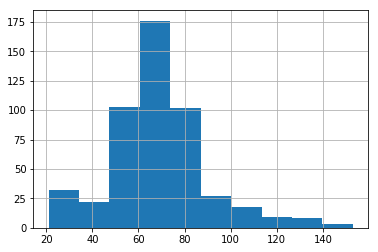

In [258]:
data_test['Lot Frontage'].hist()
print(data_test['Lot Frontage'].median())
plt.show()

535453170.0


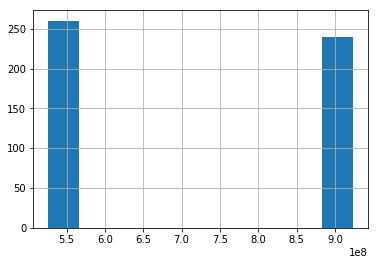

In [259]:
data_test['PID'].hist()
print(data_test['PID'].median())
plt.show()

535456015.0


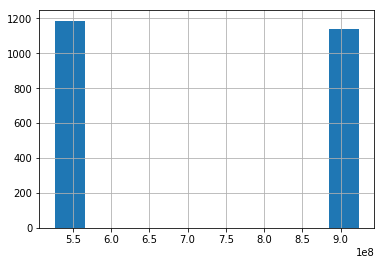

In [260]:
data_final['PID'].hist()
print(data_final['PID'].median())
plt.show()

## Questions (Greg notes)
* Shall I overwrite 'data' each time I do an update (handling outliers and NA)? Or shall I create a copy or new df each time?
* How to deal with Year build and renovation? Maybe buckets?
* For some cases I assign NaN to most frequent value. I am doing this manually. Shall I be automating it in case the data set gets refresh en enhanced? Shall I create a code to pick most frequent?
* How to handle Type 1 (+Type 2)? Or two floors? Feature Engineering?
* What happens if we keep Nans in variable data? Example of Garage?
* Shall I also clean outliers for SalePrice (output variable)?
* How shall I deal with Discrete variable in Feature encoding or engineering
* Number of rooms or bathrooms is discrete or can be considered continuous?
* Shouldn't the feature engineering step come before feature encoding to be able to encode feature engineered?
* Feature engineering needs to be applied to data_test as well?
* How to choose on which variable to apply polynomial?
* how to deal with NaN values in cases where for example Garage don't exist and i don't want to put 0? Keeping Nan seems to break Linear Regression model
* Is it correct to preprocessed test data with train data value and same arrangements?
* how to deal with variable not equal between train and test sets?